# Guided example + challenge

## First Attempt at Model

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

raw_data = pd.read_csv('./data/epi_r.csv')
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [2]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

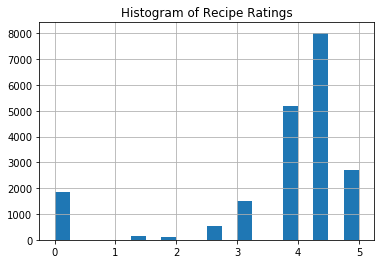

In [3]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [4]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [5]:
# from sklearn.svm import SVR
# svr = SVR()
# X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
# Y = raw_data.rating
# svr.fit(X,Y)

In [6]:
# # Actual values vs. predicted values
# plt.scatter(Y, svr.predict(X))

# # Score SVR model
# print('SVR model score:', svr.score(X, Y))

# # Cross validation
# from sklearn.model_selection import cross_val_score
# cross_val_score(svr, X, Y, cv=5)

Now there are many things that we could do here.

- The overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

- We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

- We could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

## THAT IS YOUR CHALLENGE.

- Transform this regression problem into a binary classifier and clean up the feature set. 

- You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

- Also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so? (There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews. After all, people who eat chocolate might just be happier people.)

## Using SVM to Create a Binary Classifier

I will choose to exclude nutritional information to answer the original question – can a recipe's ingredients help predict its rating?

In [7]:
# Helper functions
def get_cols_with(df, food_name):
    return [col for col in df.columns if food_name in col]

def get_uniq_cols_with(df, all_food_names):
    answer = []
    for food_name in all_food_names:
        answer += get_cols_with(df, food_name)
    return list(set(answer))

def combine_cols(df, all_cols, new_name):
    df[new_name] = [0] * df.shape[0]

    for each_col in all_cols:
        df[new_name] += df[each_col]
    
    return df.drop(all_cols, 1)

In [8]:
# Make ratings into binary categories of low (<=4) and high (> 4)
df = raw_data.copy()
# df['rating'] = ['low' if rating <= 4 else 'high' for rating in raw_data['rating']]
# print('Distribution of high vs. low ratings:', df.rating.value_counts(normalize=True))

# Drop non-ingredient columns like nutritional facts, states, cities, countries, etc.
nutritional_facts = ['calories', 'protein', 'fat', 'sodium']
df = df.drop(nutritional_facts, axis=1)

states = ['alabama', 'alaska', 'arizona', 'california', 'colorado', 'connecticut', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'nebraska', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington', 'washington, d.c.', 'west virginia', 'wisconsin']
cities = ['aspen', 'atlanta', 'beverly hills', 'boston', 'brooklyn', 'buffalo', 'cambridge', 'chicago', 'columbus', 'costa mesa', 'dallas', 'denver', 'healdsburg', 'hollywood', 'houston', 'kansas city', 'lancaster', 'las vegas', 'london', 'long beach', 'los angeles', 'louisville', 'miami', 'minneapolis', 'new orleans', 'pacific palisades', 'paris', 'pasadena', 'pittsburgh', 'portland', 'providence', 'san francisco', 'santa monica', 'seattle', 'st. louis', 'westwood', 'windsor', 'yonkers']
countries = ['australia', 'bulgaria', 'canada', 'chile', 'cuba', 'dominican republic', 'egypt', 'england', 'france', 'germany', 'guam', 'haiti', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'mexico', 'peru', 'philippines', 'spain', 'switzerland']
places = states + cities + countries
df = df.drop(places, axis=1)

holidays = get_uniq_cols_with(df, [' day', ' eve', 'new year', 'sgiving', 'christmas', 'week', 'passover']) + ['cinco de mayo', 'diwali', 'easter', 'fourth of july', 'halloween', 'hanukkah', 'kwanzaa', 'mardi gras', 'ramadan', 'rosh hashanah/yom kippur', 'sukkot']
events = get_uniq_cols_with(df, ['game', 'grill', 'bbq', 'barbecue', 'school', 'graduation', 'party', 'shower']) + ['30 days of groceries', 'anniversary', 'birthday', 'camping', 'entertaining', 'wedding', 'tailgating', 'family reunion', 'kentucky derby', 'oscars', 'parade', 'picnic', 'potluck', 'super bowl', 'oktoberfest']
seasons = get_uniq_cols_with(df, ['fall', 'spring', 'summer', 'winter'])
times = holidays + events + seasons
df = df.drop(times, axis=1)

names = ['anthony bourdain', 'dorie greenspan', 'emeril lagasse', 'harpercollins', 'house & garden', 'nancy silverton', 'suzanne goin']
df = df.drop(names, axis=1)

# Cooking / food
appliances = get_uniq_cols_with(df, ['cooker']) + ['blender', 'food processor', 'candy thermometer', 'coffee grinder', 'double boiler', 'juicer', 'microwave', 'mixer', 'mortar and pestle', 'pasta maker', 'smoker', 'wok']
techniques = get_uniq_cols_with(df, ['kitchen', 'freeze', 'cook', 'fry']) + ['bake', 'boil', 'braise', 'brine', 'broil', 'chill', 'deep-fry', 'marinate', 'poach', 'roast', 'rub', 'sauté', 'simmer', 'steam', 'stir-fry']
foods = get_uniq_cols_with(df, ['cake', 'condiment', 'dessert', 'drink', 'pie', 'salad', 'sandwich', 'soup', 'stew', ' meal', 'casserole']) + ['aperitif', 'appetizer', 'breakfast', 'brunch', 'buffet', 'condiment', 'digestif', 'dinner', 'dip', "hors d'oeuvre", 'leftovers', 'lunch', 'lasagna', 'muffin', 'omelet', 'pizza', 'side', 'smoothie', 'snack', 'taco', 'waffle']
specs = get_uniq_cols_with(df, ['friendly', ' free', '-free', 'high ', 'low ', 'no ', '-no', 'no-', 'healthy', 'quick', 'kosher']) + ['organic', 'gourmet', 'raw', 'sugar conscious', 'tested & improved']
diets = ['paleo', 'pescatarian', 'vegan', 'vegetarian']
drinks = ['margarita', 'martini', 'iced coffee', 'iced tea', 'egg nog']
cooking = appliances + techniques + foods + specs + diets + drinks
df = df.drop(cooking, axis=1)

phrases = get_uniq_cols_with(df, ['epi ', 'cookbook', 'recipe', 'gift']) + ['#wasteless', 'bon appétit', 'bon app��tit', 'weelicious']
categories = ['advance prep required']
non_ingredients = ['title']
misc = phrases + categories + non_ingredients
df = df.drop(misc, axis=1)

all_sums = df.drop('rating', axis=1).sum()
sums_df = pd.DataFrame(all_sums)
ranked_sums = sums_df.sort_values(0, ascending=False)
# top_50_ingredients = ranked_sums[:50].index.values
bottom_50_ingredients = ranked_sums[len(ranked_sums.index)-50:].index.values

# print('Top 50:', top_50_ingredients)
print('Bottom 50:', bottom_50_ingredients)

# top_answer = [0]*len(df.index)
bottom_answer = [0]*len(df.index)

# for ingred in top_50_ingredients:
#     top_answer = top_answer + df[ingred]
    
for ingred in bottom_50_ingredients:
    bottom_answer = bottom_answer + df[ingred]

# df['top 50 ingredients'] = top_answer
df['bottom 50 ingredients'] = bottom_answer
df.head()

Bottom 50: ['marshmallow' 'eau de vie' 'grains' 'tart' 'lychee' 'meatball' 'skewer'
 'spritzer' 'rabbit' 'octopus' 'poblano' 'biscuit' 'pomegranate juice'
 'cobbler/crumble' 'yuca' 'house cocktail' 'marscarpone' 'salsa'
 'apple juice' 'midori' 'granola' 'lingonberry' 'cranberry sauce'
 'flat bread' 'rosé' 'sardine' 'grappa' 'hamburger' 'bran' 'stock'
 'soufflé/meringue' 'macaroni and cheese' 'brownie' 'chili' 'hummus'
 'orzo' 'frittata' 'custard' 'meatloaf' 'sorbet' 'sourdough'
 'cr��me de cacao' 'caviar' 'grand marnier' 'crêpe' 'fritter' 'marinade'
 'burrito' 'quiche' 'mezcal']


,rating,alcoholic,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,...,whiskey,white wine,whole wheat,wild rice,wine,yogurt,yuca,zucchini,turkey,bottom 50 ingredients
0,2.500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# # TODO: Tune model
# # Look at data visually BEFORE building features
# # boxplots and hists
# for col in bottom_50_ingredients:
#     plt.scatter(df[col], df['rating'])
#     plt.show()

In [10]:
# Consolidate meats
meat_cols = get_uniq_cols_with(df, ['bacon', 'beef', 'brisket', 'chicken', 'duck', 'goose', 'ham', 'meat', 'lamb', 'pork', 'prosciutto', 'rabbit', 'sausage', 'steak', 'turkey', 'veal', 'venison'])
df = combine_cols(df, meat_cols, 'new_meat')

# Consolidate seafood
fish_cols = get_uniq_cols_with(df, ['seafood', 'fish', 'anchovy', 'clam', 'cod', 'crab', 'halibut', 'lobster', 'mussel', 'octopus', 'oyster', 'poultry', 'quail', 'salmon', 'sardine', 'scallop', 'shrimp', 'snapper', 'squid', 'tilapia', 'tuna', 'trout', 'bass'])
df = combine_cols(df, fish_cols, 'new_fish')

# Consolidate alcohols
alc_cols = get_uniq_cols_with(df, ['alcohol', 'spirit', 'liqu', 'eau de vie', 'frangelico', 'spritzer', 'beer', 'brandy', 'campari', 'champagne', 'chartreuse', 'cocktail', 'cognac', 'wine', 'kirsch', 'créme de cacao', 'cr��me de cacao', 'gin', 'grand marnier', 'kahlúa', 'mezcal', 'midori', 'pernod', 'tequila', 'triple sec', 'whiskey', 'amaretto', 'bitters', 'bourbon', 'port', 'rosé', 'rum', 'sake', 'sangria', 'scotch', 'sherry', 'vermouth', 'vodka'])
df = combine_cols(df, alc_cols, 'new_alc')

# Consolidate fruits
fruit_cols = get_uniq_cols_with(df, ['fruit', ' juice', 'citrus', 'raisin', 'apple', 'apricot', 'banana', 'tamarind', 'cantaloupe', 'cherry', 'currant', 'tangerine', 'papaya', 'date', 'grape', 'guava', 'orange', 'pear', 'plantain', 'prune', 'berry', 'fig', 'honeydew', 'kiwi', 'kumquat', 'lemon', 'lime', 'lychee', 'mango', 'melon', 'nectarine', 'peach', 'persimmon', 'plum', 'pomegranate', 'quince'])
df = combine_cols(df, fruit_cols, 'new_fruit')

# Consolidate veggies
veg_cols = get_uniq_cols_with(df, ['vegetable', 'green', 'legume', 'arugula', 'asparagus', 'artichoke', 'avocado', 'bean', 'beet', 'bok choy', 'broccoli', 'brussel sprout', 'cabbage', 'cauliflower', 'celery', 'chard', 'chickpea', 'chili', 'corn', 'cucumber', 'carrot', 'eggplant', 'garlic', 'jalapeño', 'jícama', 'kale', 'leek', 'lentil', 'lettuce', 'mushroom', 'mustard', 'okra', 'olive', 'onion', 'pea', 'pepper', 'pickles', 'poblano', 'potato', 'pumpkin', 'rutabaga', 'radish', 'rhubarb', 'shallot', 'spinach', 'squash', 'sugar snap pea', 'sweet potato/yam', 'tomato', 'tomatillo', 'turnip', 'watercress', 'yuca', 'zucchini'])
df = combine_cols(df, veg_cols, 'new_veg')

# Consolidate herbs and spices
spice_cols = get_uniq_cols_with(df, ['herb', 'spice', 'anise', 'basil', 'endive', 'capers', 'cardamom', 'chive', 'escarole', 'paprika', 'cilantro', 'cinnamon', 'coriander', 'cumin', 'fennel', 'thyme', 'vanilla', 'parsley', 'parsnip', 'oregano', 'dill', 'rosemary', 'clove', 'ginger', 'nutmeg', 'poppy', 'saffron', 'sage', 'tarragon', 'mint'])
df = combine_cols(df, spice_cols, 'new_spice')

# Consolidate nuts
nut_cols = get_uniq_cols_with(df, ['nut', 'almond', 'cashew', 'pecan', 'pistachio', 'walnut'])
df = combine_cols(df, nut_cols, 'new_nut')

# Consolidate dairy
dairy_cols = get_uniq_cols_with(df, ['dairy', 'mozzarella', 'marscarpone', 'cheese', 'brie', 'cheddar', 'feta', 'fontina', 'gouda', 'monterey jack', 'parmesan', 'ricotta', 'butter', 'milk', 'cream', 'yogurt'])
df = combine_cols(df, dairy_cols, 'new_dairy')

# Consolidate byproducts
byprod_cols = get_uniq_cols_with(df, ['egg', 'caviar'])
df = combine_cols(df, byprod_cols, 'new_byprod')

# Consolidate grains
grain_cols = get_uniq_cols_with(df, ['grain', 'couscous', 'barley', 'bran', 'granola', 'wheat', 'rice', 'rye', 'oat', 'orzo', 'quinoa', 'bread', 'dough', 'biscuit', 'pasta', 'noodle'])
df = combine_cols(df, grain_cols, 'new_grain')

# Consolidate condiments
condiment_cols = get_uniq_cols_with(df, ['sauce', ' oil', 'vinegar', 'salsa', 'wasabi', 'jam', 'hummus', 'mayonnaise', 'molasses', 'honey'])
df = combine_cols(df, condiment_cols, 'new_condiment')

# Consolidate sweets and desserts
sweet_cols = get_uniq_cols_with(df, ['chocolate', 'sorbet', 'meringue', 'pastry', 'custard', 'syrup', 'brownie', 'candy', 'marshmallow'])
df = combine_cols(df, sweet_cols, 'new_sweet')

# Consolidate drinks
drink_cols = get_uniq_cols_with(df, ['coffee', 'tea'])
df = combine_cols(df, drink_cols, 'new_drink')

print(len(df.columns))
print(df.columns)
df.head()

45
Index(['rating', 'bulgur', 'burrito', 'calvados', 'caraway', 'crêpe', 'curry',
       'frittata', 'fritter', 'grappa', 'mandoline', 'marinade', 'marsala',
       'punch', 'purim', 'quiche', 'radicchio', 'ramekin', 'seed', 'self',
       'semolina', 'sesame', 'shavuot', 'skewer', 'soy', 'stock',
       'stuffing/dressing', 'tapioca', 'tart', 'tofu', 'tortillas',
       'bottom 50 ingredients', 'new_meat', 'new_fish', 'new_alc', 'new_fruit',
       'new_veg', 'new_spice', 'new_nut', 'new_dairy', 'new_byprod',
       'new_grain', 'new_condiment', 'new_sweet', 'new_drink'],
      dtype='object')


,rating,bulgur,burrito,calvados,caraway,crêpe,curry,frittata,fritter,grappa,...,new_fruit,new_veg,new_spice,new_nut,new_dairy,new_byprod,new_grain,new_condiment,new_sweet,new_drink
0,2.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0


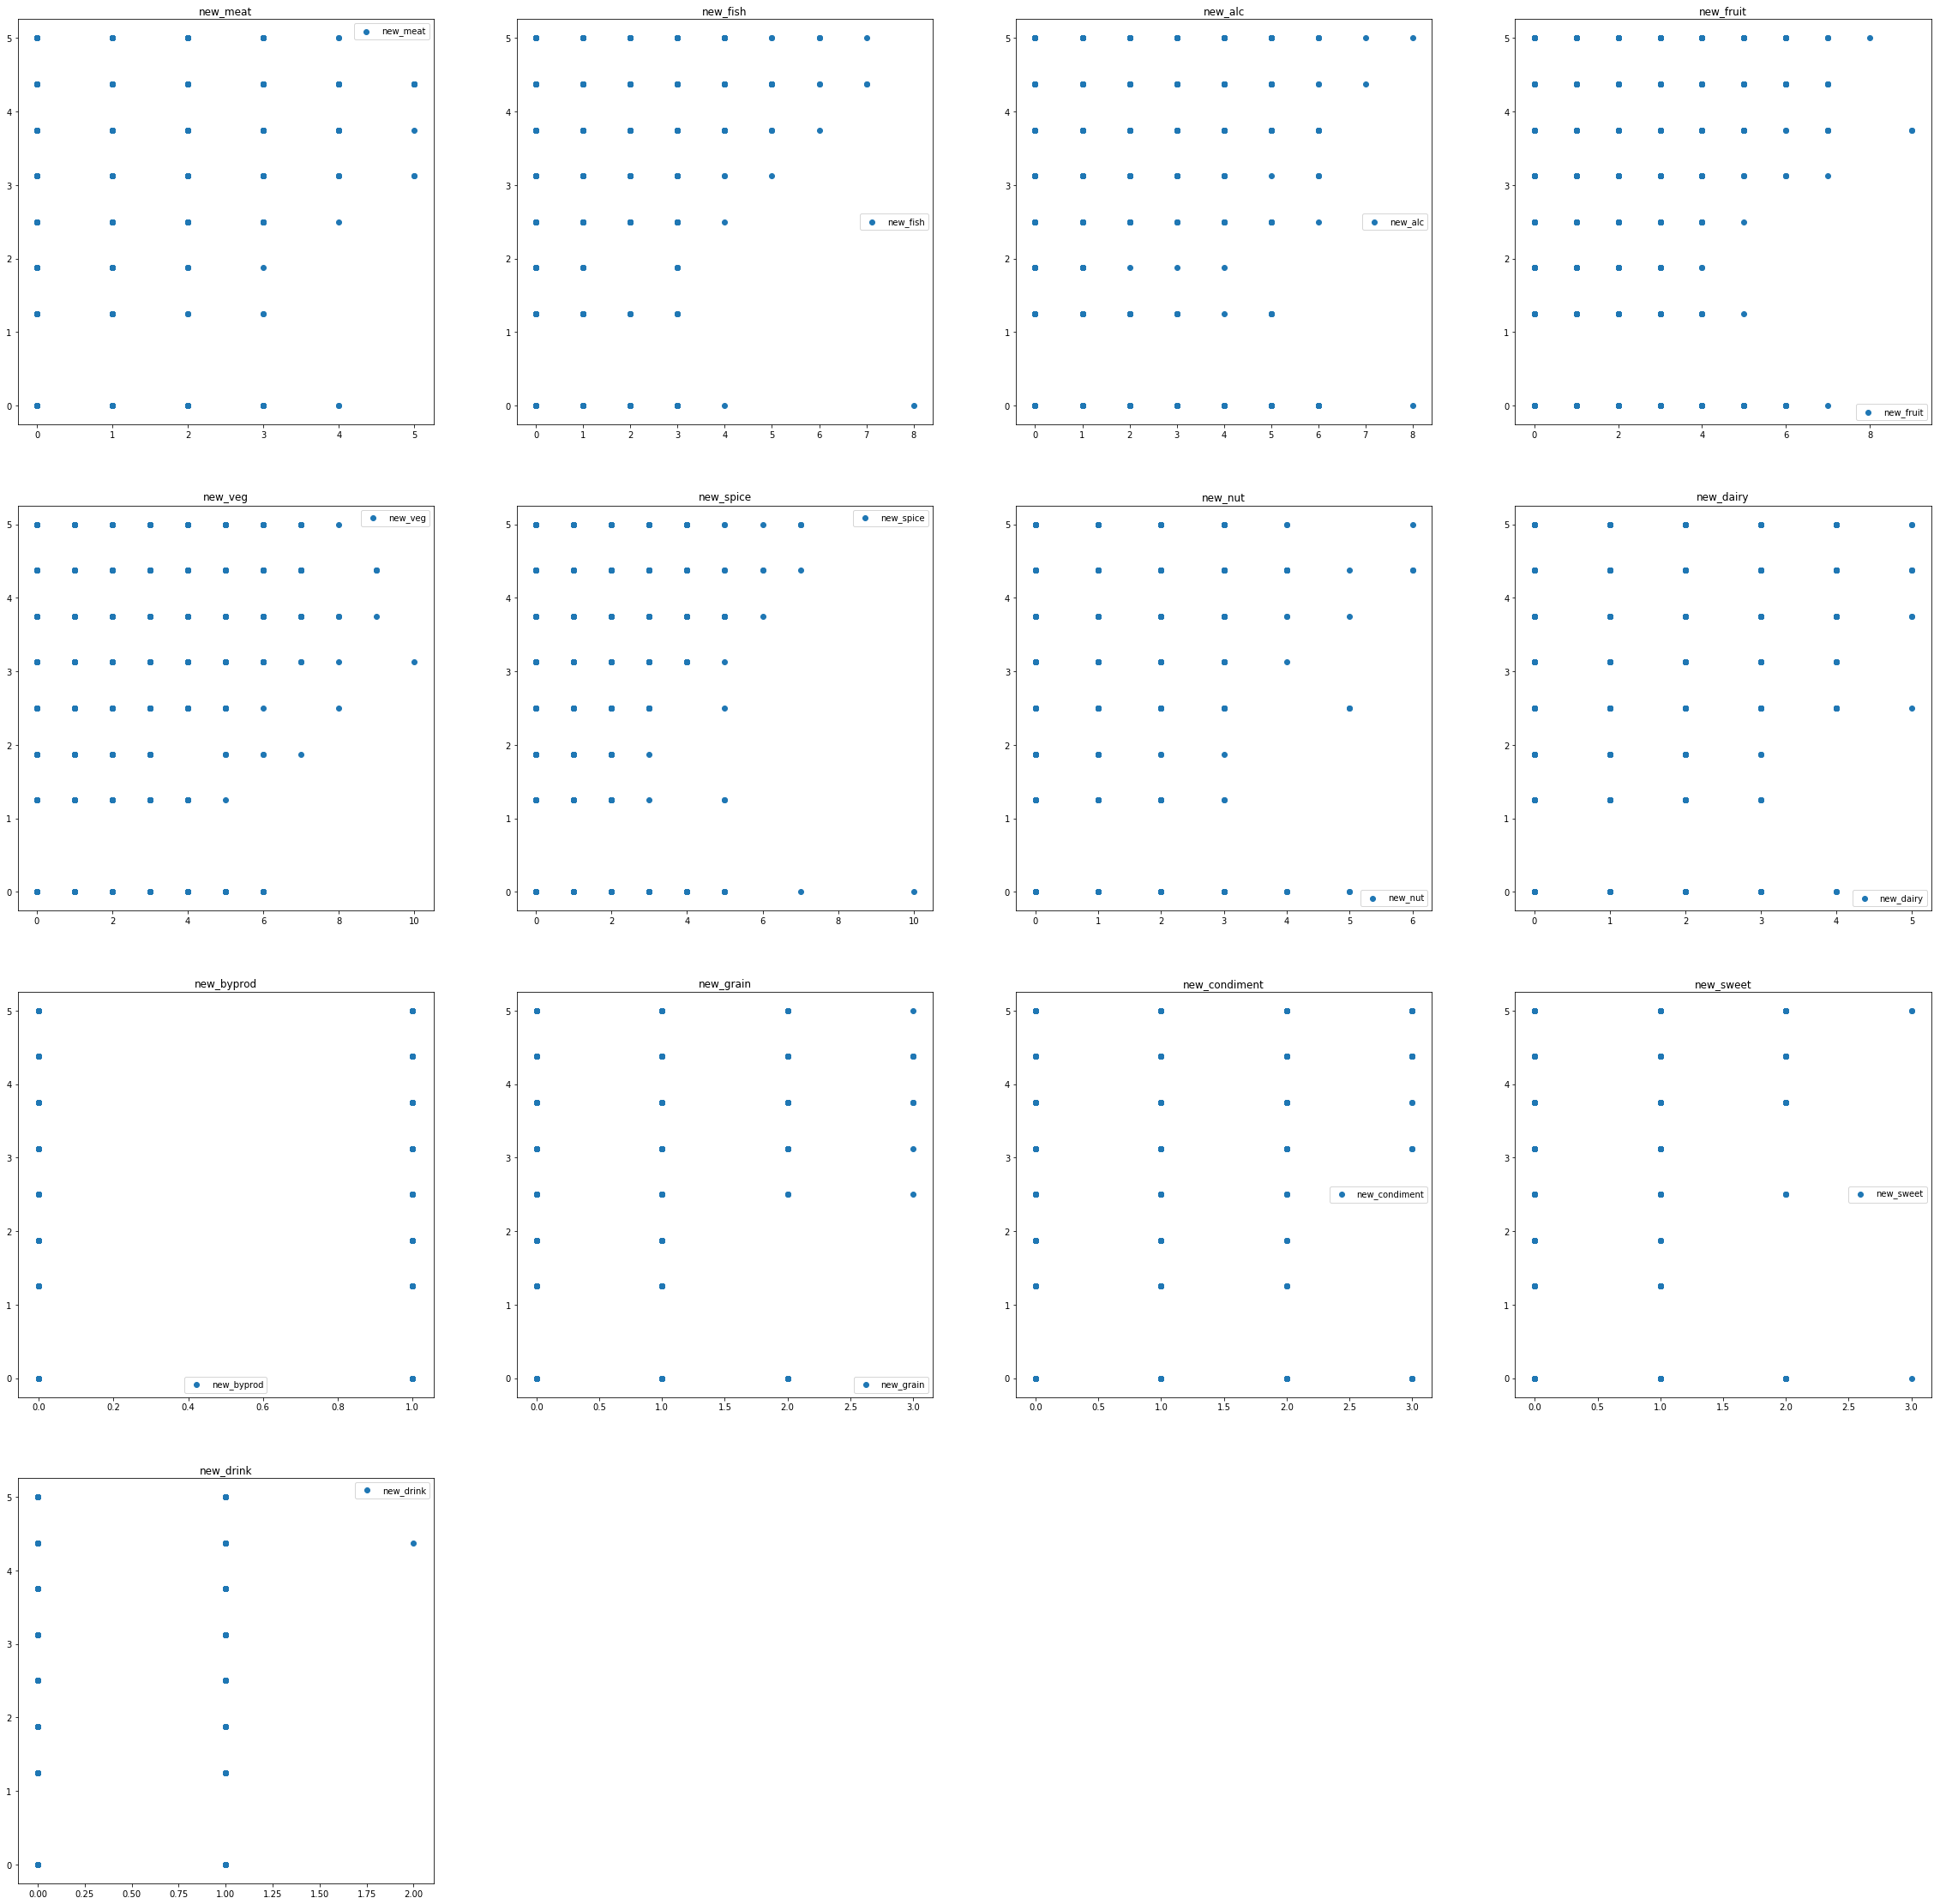

In [11]:
new_cols = [col for col in df.columns if 'new_' in col]
# all_cols = df.columns

plt.figure(figsize=(40,40))

for idx, col in enumerate(new_cols):
    plt.subplot(4, 4, idx + 1)
    plt.scatter(df[col], df['rating'], label=col)
    plt.legend()
    plt.title(col)
    
plt.show()

In [12]:
# PCA to get down to 30 features
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

pca_num_components = [35, 30, 25]

def get_pca_cross_val_score(num_components):
    X = df.drop('rating', 1)
    
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(X)
    
    svc = SVC()
    Y = df['rating']
    X = principal_components
    
    print(num_components, cross_val_score(svc, X, Y, cv=5))

for num_components in pca_num_components:
    get_pca_cross_val_score(num_components)

ValueError: Unknown label type: 'continuous'

In [ ]:
df = df[['rating', 'top 50 ingredients', 'bottom 50 ingredients'] + [col for col in df.columns if 'new_' in col]]

In [ ]:
svc = SVC()

X = df.drop(['rating'], 1)
Y = df['rating']
svc.fit(X, Y)

In [ ]:
# Actual values vs. predicted values
# plt.scatter(Y, svc.predict(X))

# Score SVR model
print('SVC model score:', svc.score(X, Y))

# Cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X, Y, cv=5)

In [ ]:
pd.crosstab(svc.predict(X), Y, rownames=['Predicted'], colnames= ['Actual'], margins=True)